In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2

from imageai.Detection import ObjectDetection

In [2]:
### UTILITY FUNCTION: EXTRACT FRAMES FROM VIDEO ###

def extract_frames(video_path, fr=12):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    id_frame = 0
    while id_frame<=total_frames:
        cap.set(1, id_frame)
        success, frame = cap.read()
        if type(frame) != type(None):
            frames.append(frame)
        id_frame+=fr
    return frames

In [3]:
### EXECUTE EXTRACTION ###

frames = extract_frames('store_video.mp4')
len(frames)

149

(-0.5, 639.5, 479.5, -0.5)

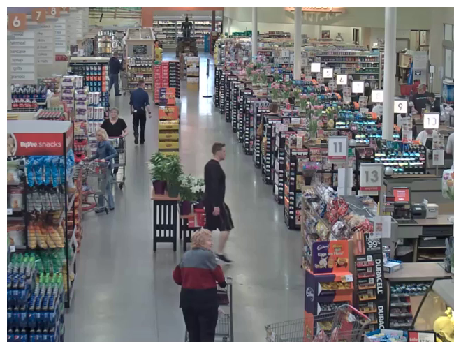

In [4]:
### PLOT STORE LAYOUT ###

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGRA2RGB))
plt.axis('off')

In [5]:
### INITIALIZE IMAGEAI ###

detector = ObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath("yolo-tiny.h5")
detector.loadModel()
custom_objects = detector.CustomObjects(person=True)

In [6]:
### PEOPLE DETECTION ON EXTRACTED FRAMES ###

rect_h = 20

final_img = []
for img in tqdm(frames):

    detected_image_array, detections = detector.detectCustomObjectsFromImage(
        input_image=img, input_type="array", output_type="array",
        custom_objects=custom_objects, minimum_percentage_probability=75)
    
    new_img = np.zeros(img.shape)
    for person in detections:
        y_min = person['box_points'][1]
        x_min = person['box_points'][0]
        y_max =  person['box_points'][3]
        x_max =  person['box_points'][2]
        cv2.rectangle(new_img, (x_min,y_max-rect_h), (x_max,y_max), (0,255,0), -1)
        
    final_img.append(new_img[:,:,1]/255)

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [02:31<00:00,  1.04it/s]


In [7]:
### CALCULATE FREQUENCIES ###

combi_img = np.sum(final_img, axis=0)
combi_img[combi_img.shape[0] - int(rect_h+rect_h/3):,:] = 0

(-0.5, 639.5, 479.5, -0.5)

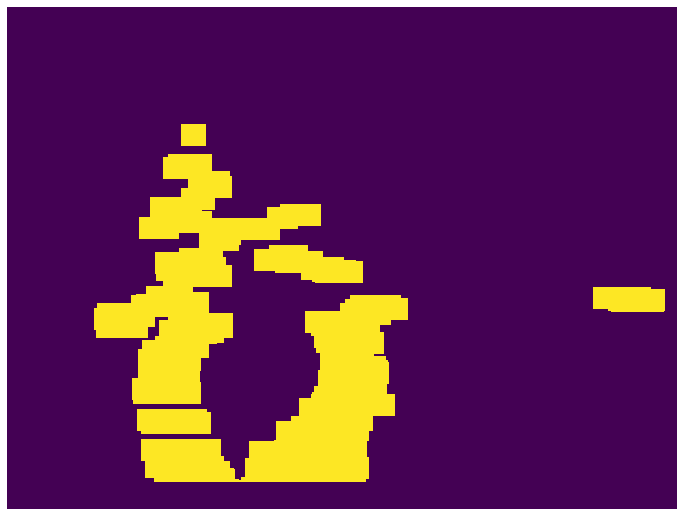

In [8]:
### BUILD TRACK MASK ###

track_img = (combi_img != 0) +0 

plt.figure(figsize=(12,12))
plt.imshow(track_img)
plt.axis('off')

(-0.5, 639.5, 479.5, -0.5)

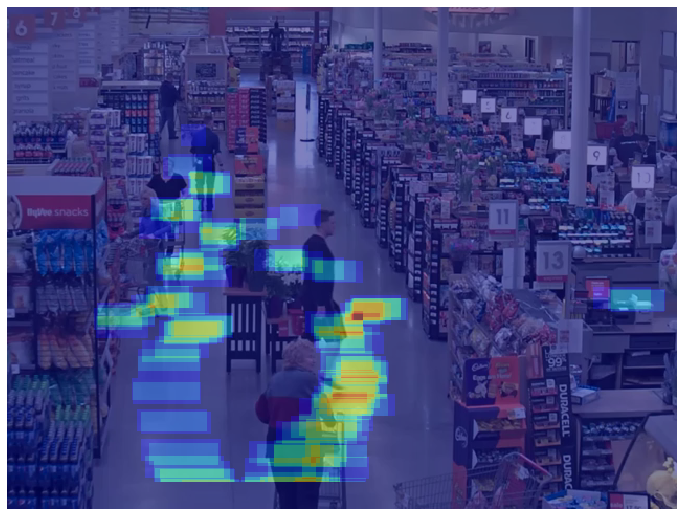

In [9]:
### BUILD HEATMAP ###

img_background = cv2.cvtColor(frames[0], cv2.COLOR_BGRA2RGB)

plt.figure(figsize=(12,12))
plt.imshow(img_background)
plt.imshow(combi_img, cmap='jet', alpha=0.5)
plt.axis('off')